# Miniproyecto 3 / ModSim

    - Rodrigo Zea
    - Sebastian Arriola

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Seed para generador de númerosa aleatorios uniformes

In [2]:
random.seed(69)

## Generadores de Números Aleatorios

In [3]:
def poisson(lam=1):
    return -((1.0 / lam) * np.log(random.random()))
        
def exponential(lam=1):
    return -((1.0 / lam) * np.log(random.random()))

## Variables Globales de Simulacion

In [4]:
# amount of servers rented at Ants
SERVERS = 10
# Max requests per minute and second
MAX_REQ_PER_MIN = 2400
MAX_REQ_PER_SEC = MAX_REQ_PER_MIN / 60
# Gorilla computation power, 100 requests per second
GORILLA_REQ_PER_SEC = 100
GORILLA_SEC_PER_REQ = 1 / GORILLA_REQ_PER_SEC
# Ants computation power, 10 requests per second
ANTS_REQ_PER_SEC = 10
ANTS_SEC_PER_REQ = 1 / ANTS_REQ_PER_SEC

# simulation time
T = 3600

## Simulación para 1 Servidor (Gorilla)

In [7]:
def g_server_simulation(offline_time=3600):
    # Offline time
    T = 3600
    na = 0
    nd = 0
    n = 0

    # Generate T0

    # initial time of next customer arrival
    ta = poisson(lam=MAX_REQ_PER_SEC)
    # current time is set to next arrival
    t = ta

    td = math.inf

    # for output data, keep track of arrival times and departures of customers
    arrivals, departures = {}, {}
    ytot = []

    while t <= T or n > 0:
        if (ta <= td and ta <= T):
            t = ta
            na += 1
            n += 1
            # Generate Tt
            ta = t + poisson(lam=GORILLA_REQ_PER_SEC)
            if (n == 1):
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y
                
            # store arrival time of customer  
            arrivals[na] = t
            ytot.append(Y)
        elif (td < ta and td <= T):
            t = td
            n -= 1
            nd += 1

            if (n == 0):
                td = math.inf
            else:
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y
            # store departure time of customer
            departures[nd] = t
            ytot.append(Y)
        elif (min(ta, td) > T and n > 0):
            t = td
            n -= 1
            nd += 1

            if (n > 0):
                # generar y
                Y = exponential(lam=GORILLA_REQ_PER_SEC)
                # generate y and update sig exit
                td = t + Y   
            # store departure time of customer
            departures[nd] = t
            ytot.append(Y)
        elif (min(ta, td) > T and n == 0):
            tp = max(t - T, 0)
            break

    print('Simulation finished...')
    return (
        t,
        na, 
        nd, 
        arrivals, 
        departures,
        ytot)

In [9]:
(t, na, nd, arrivals, departures, ytot) = g_server_simulation()

Simulation finished...


In [10]:
# Some calcs to display results later
busy = sum(ytot)/3600
idle = 3600-sum(ytot)

diff = min(len(arrivals), len(departures))


dep = list(departures)
arri = list(arrivals)

times = [(dep[i]-arri[i]) for i in range(diff)]
avgTime = sum(times)/diff

avgProcs = len(departures)/3600

In [11]:
print("""
------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------
""")
print("Momento de la ultima salida: " + str(list(departures)[-1]))
print("Numero de procesos atendidos: " + str(nd))
print("Tiempo procesando: " + str(busy))
print("Tiempo idle: " + str(idle))
print("Tiempo total de los procesos en cola: " + str(sum(ytot)))
print("Tiempo promedio de un proceso en cola: " + str(avgTime))
print("Numero promedio de procesos en cola: " + str(avgProcs))


------------------------------------------------------------------
                     ANALISIS DE RESULTADOS
------------------------------------------------------------------

Momento de la ultima salida: 360116
Numero de procesos atendidos: 360116
Tiempo procesando: 3.012648919614821
Tiempo idle: -7245.536110613357
Tiempo total de los procesos en cola: 10845.536110613357
Tiempo promedio de un proceso en cola: 0.0
Numero promedio de procesos en cola: 100.03222222222222


## Simulación para N Servidores

In [39]:
def n_server_simulation(n_servers=1, offline_time=3600):
    # Offline Time
    T = offline_time
    # System State
    n = 0
    # arrivals and departures by time t
    na, nd = 0, 0

    # number of customers served by servers
    customers_attended_per_server = [0 for _ in range(n_servers)]
    # holds customer id currently being attended for each server of 0 if server is idle
    current_server_state = [0 for _ in range(n_servers)]

    # time past T when last customer departs
    tp = 0

    # initial time of next customer departure
    next_departures = [math.inf for _ in range(n_servers)]

    # initial time of next customer arrival
    ta = poisson(lam=MAX_REQ_PER_SEC)
    # current time is set to next arrival
    t = ta

    # for output data, keep track of arrival times and departures of customers
    arrivals, departures = {}, {}
    # keep track of server busy time
    servers_busy_time = [0 for _ in range(n_servers)]
    # to keep track of queue and dequeue time
    q_times, dq_times = {}, {}

    while t <= T or n > 0:
        # attend a customer arrival
        if (ta <= np.amin(next_departures)) and ta <= T:
            # advance simulation time to next arrival
            t = ta
            # number of customers arrived by time t increases by 1
            na = na + 1
            # generate time of next customer arrival
            ta = t + poisson(lam=MAX_REQ_PER_SEC)
            # store arrival time of customer
            arrivals[na] = t

            # there is some server available, find next available server and queue
            if n < n_servers:
                for i in range(n_servers):
                    if current_server_state[i] == 0:
                        current_server_state[i] = na
                        next_departures[i] = t + exponential(lam=ANTS_REQ_PER_SEC)
                        break

            # system is full
            else:
                q_times[na] = t

            # no matter the case, increase customers in system by 1
            n = n + 1

        # there is a departure < ta
        else:
            # get the index of the next departure
            min_time = math.inf
            server_index = 0
            for i in range(n_servers):
                if next_departures[i] < min_time:
                    min_time = next_departures[i]
                    server_index = i

            # advance simulation time to next departure
            t = next_departures[server_index]
            # increase amount of customers departed by time t
            nd = nd + 1
            # increase amount of customers served by server n
            temp = customers_attended_per_server[server_index]
            customers_attended_per_server[server_index] = temp + 1
            # store output data
            departures[nd] = t
            servers_busy_time[server_index] += (departures[nd] - arrivals[nd])

            # decrease customers in system by 1
            n = n - 1

            # if there is a customer on the queue
            if n >= n_servers:
                m = np.amax(current_server_state)
                current_server_state[server_index] = m + 1
                next_departures[server_index] = t + exponential(lam=ANTS_REQ_PER_SEC)
                dq_times[current_server_state[server_index]] = t
            else:
                current_server_state[server_index] = 0
                next_departures[server_index] = math.inf

    print('Simulation finished...')
    return (
        t,
        na, 
        nd, 
        customers_attended_per_server, 
        current_server_state, 
        servers_busy_time,
        tp, 
        arrivals, 
        departures,
        q_times,
        dq_times)

In [40]:
def print_server_time_stats(cust_per_server, serv_busy_time):
    n_servers = len(cust_per_server)
    columns = ('Customers Served', 'Busy Time', 'Idle Time')
    rows = [['Server %d' % x] for x in range(n_servers)]
    cell_text = []
    data = [['Customers Served', 'Busy Time (s)', 'Idle Time (s)']]

    for i in range(n_servers):
        rows[i].append(str(cust_per_server[i]))
        rows[i].append('%1.2f' % serv_busy_time[i])
        if serv_busy_time[i] <= T:
            rows[i].append('%1.2f' %(T - serv_busy_time[i]))
        else:
            rows[i].append('0.0')
        data.append(rows[i])

    column_headers = data.pop(0)
    row_headers = [x.pop(0) for x in data]
    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    for row in data:
        cell_text.append([f'{x}' for x in row])

    the_table = plt.table(cellText=cell_text,
                          rowLabels=row_headers,
                          rowColours=rcolors,
                          rowLoc='right',
                          colColours=ccolors,
                          colLabels=column_headers,
                          loc='center')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(16)
    the_table.scale(2, 1.5)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)

    plt.show()

In [41]:
def print_server_queue_stats(q_times, dq_times, finish_time):
    q_sum = 0
    for k in q_times:
        q_sum += (dq_times[k] - q_times[k])

    req_time = 0
    for k in arrivals:
        req_time += (departures[k] - arrivals[k])

    print(f'### Amount of requests received: {na}')
    print(f'### Total busy time: {req_time}')
    print(f'### Average request service time: {req_time / len(arrivals)}')
    print('### Last request was served %1.3f seconds after the offline time.' % (finish_time - T))
    print(f'### Total requests that were queued: {len(q_times)}')
    print(f'### Total queue time: {q_sum}')
    print(f'### Average queue time: {q_sum / len(q_times) if len(q_times) > 0 else 0}')

In [66]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=10)

Simulation finished...


## Estadísticas

In [67]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 143687


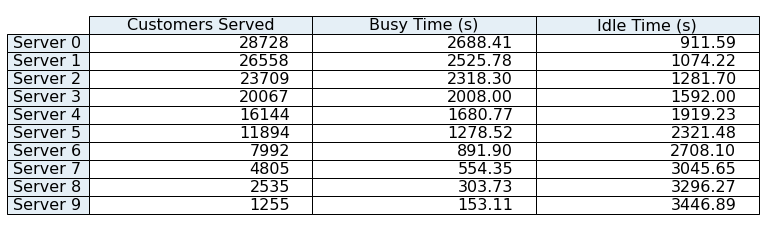

In [68]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [69]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Amount of requests received: 143687
### Total busy time: 14402.864801618914
### Average request service time: 0.10023777239151012
### Last request was served 0.143 seconds after the offline time.
### Total requests that were queued: 1219
### Total queue time: 20.289337172180275
### Average queue time: 0.016644247064955108


## Task 2
Determine empíricamente cuántos servidores se necesitaría "alquilar" en Ants Smart Computing para asegurar que siempre habrá al menos 1 servidor disponible para atender una solicitud dada.

In [70]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=30)

Simulation finished...


In [71]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 144172


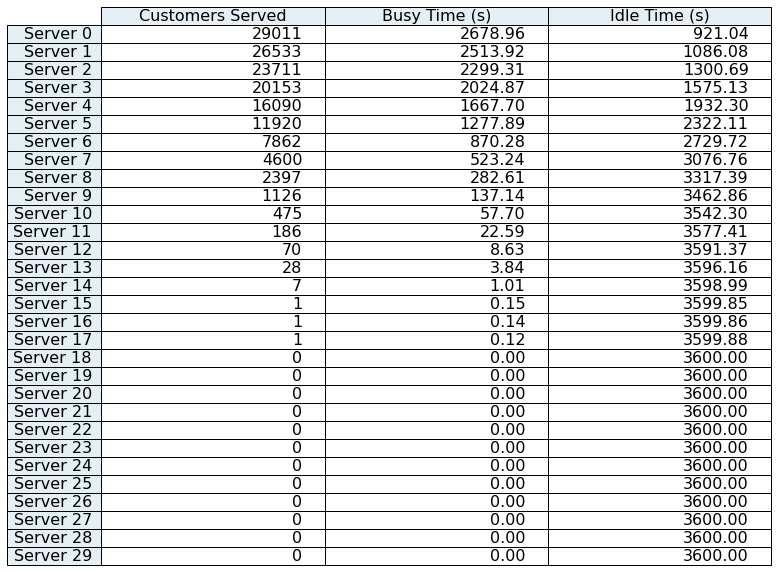

In [72]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [73]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Amount of requests received: 144172
### Total busy time: 14370.089066388606
### Average request service time: 0.09967323104617128
### Last request was served 0.166 seconds after the offline time.
### Total requests that were queued: 0
### Total queue time: 0
### Average queue time: 0


## Task 3 y 4
Resolver el task 1 y 2 para 6,000 solicitudes por minuto

In [74]:
# amount of servers rented at Ants
SERVERS = 10
# Max requests per minute and second
MAX_REQ_PER_MIN = 6000
MAX_REQ_PER_SEC = MAX_REQ_PER_MIN / 60
# Gorilla computation power, 100 requests per second
GORILLA_REQ_PER_SEC = 100
GORILLA_SEC_PER_REQ = 1 / GORILLA_REQ_PER_SEC
# Ants computation power, 10 requests per second
ANTS_REQ_PER_SEC = 10
ANTS_SEC_PER_REQ = 1 / ANTS_REQ_PER_SEC

# simulation time
T = 3600

#### N Servidores

In [75]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=10)

Simulation finished...


In [76]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 360000


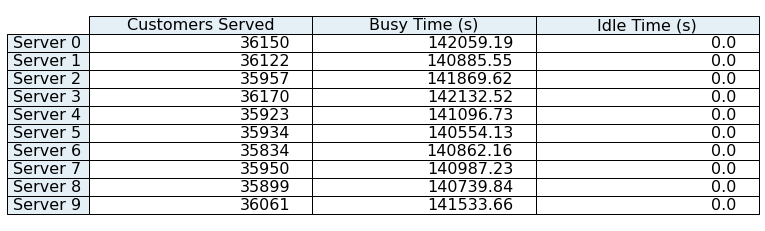

In [77]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [78]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Amount of requests received: 360000
### Total busy time: 1412720.6248828077
### Average request service time: 3.9242239580077993
### Last request was served 0.597 seconds after the offline time.
### Total requests that were queued: 358387
### Total queue time: 1376756.9525713928
### Average queue time: 3.8415370885980593


In [79]:
(
    finish_time,
    na, 
    nd, 
    customers_attended_per_server, 
    current_server_state, 
    servers_busy_time,
    tp, 
    arrivals, 
    departures,
    q_times,
    dq_times
) = n_server_simulation(n_servers=30)

Simulation finished...


In [80]:
print(f'Total de solicitudes servidas: {na}')

Total de solicitudes servidas: 360402


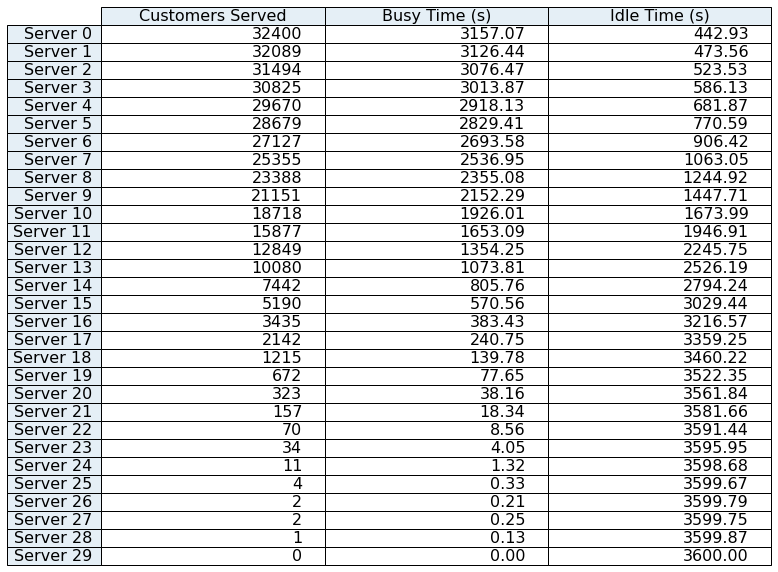

In [81]:
print_server_time_stats(customers_attended_per_server, servers_busy_time)

In [82]:
print_server_queue_stats(q_times, dq_times, finish_time)

### Amount of requests received: 360402
### Total busy time: 36155.71285916173
### Average request service time: 0.10032051114911052
### Last request was served 0.358 seconds after the offline time.
### Total requests that were queued: 0
### Total queue time: 0
### Average queue time: 0


- Para el Task 2, ahora con un máximo de 6,000 solicitudes por minuto, se necesitarían 30 servidores para garantizar que siempre habrá un servidor disponible para atender una solicitud dada.

## Task 5
Emita una recomendación a la junta directiva.

- asdf